**Introduction**



This dataset includes 5 different rice types images with 15000 images for every category. And our task is to make a classification model that could correctly predict the 5 kinds of rice.Rice Types
Arbori,
Basmati,
Ipsala,
Jasmine,
Karacadag


# **Import Libraries**

In [2]:
# import necessary libraries and tools 

# Tensorflow Framework and keras
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras import models, layers, optimizers
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

from sklearn.metrics import confusion_matrix, classification_report

import os                                  # To works with main OS commands
import random                              # To generate random numbers
import pandas as pd                        # To words with DataFrames
import numpy as np                         # To works with arrays
import matplotlib.pyplot as plt            # for visualization
import seaborn as sns                      # for visualization
from termcolor import colored              # for colorfull and bold outputs


# Set seaborn plot style to darkgrid
sns.set_style('darkgrid')

print(colored('Your hardware uses : ', 'blue', attrs=['bold']))
if len(tf.config.list_physical_devices('GPU')) == 0 :
    print(colored('CPU', 'green', attrs=['bold']))
else :
    print(colored('GPU ', 'green', attrs=['bold']))



2025-11-16 13:01:32.200848: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763298092.361541      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763298092.405382      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Your hardware uses : 
GPU 


# **Read Data**

In [3]:
# locatoin of stored dataset
base_dir = '/kaggle/input/rice-image-dataset/Rice_Image_Dataset'

# loop over dataset folder to detect classes
classes = [class_name for class_name in os.listdir(base_dir) if class_name]

# remove .txt and file in classes and print it
classes.remove('Rice_Citation_Request.txt')
print(classes)

['Karacadag', 'Basmati', 'Jasmine', 'Arborio', 'Ipsala']


# **Image Count and Classes**

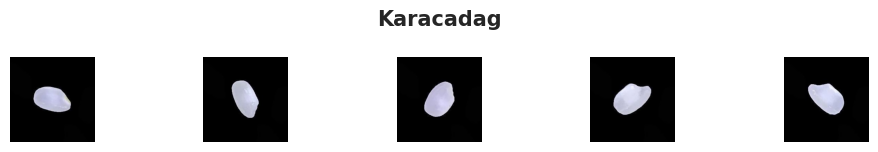

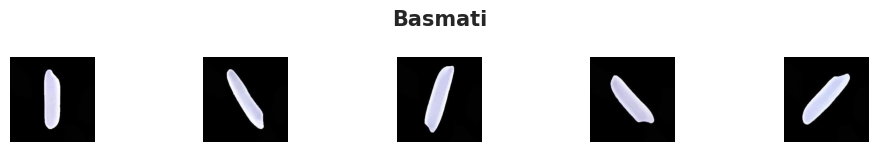

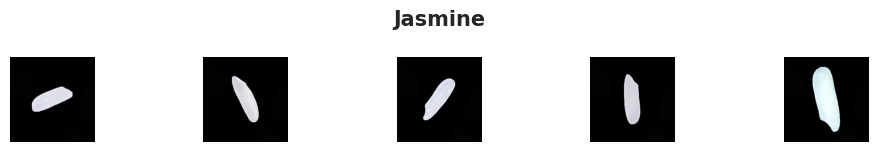

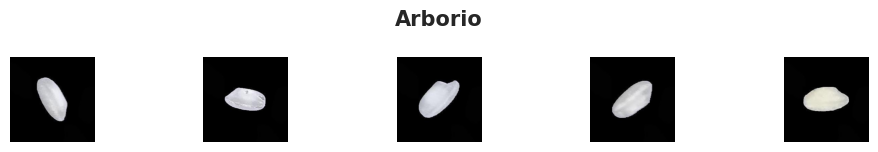

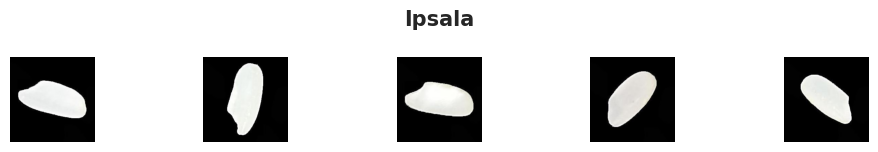

In [4]:
for class_name in classes :
    # print(class_name)
    class_path = os.path.join(base_dir, class_name)
    # print(class_path)
    images = os.listdir(class_path)
    random_images = random.choices(images, k=5)
    # print(random_images)
    fig, ax = plt.subplots(1, 5, figsize=(10, 1.5))
    for i in range(5) :
        plt.suptitle(class_name, fontsize=15, fontweight='bold')
        img = os.path.join(class_path, random_images[i])
        img = keras.utils.load_img(img)
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.tight_layout()

# **Number of Image Per Classes**

In [5]:
import pandas as pd
import plotly.express as px


# 1. Prepare the Data
# The dataset is perfectly balanced with 15,000 images per class.
data = {
    'Class_Name': ['Karacadag', 'Basmati', 'Jasmine', 'Arborio', 'Ipsala'],
    'Number_of_Images': [15000, 15000, 15000, 15000, 15000]
}
df = pd.DataFrame(data)

# 2. Create the Interactive Horizontal Bar Plot
# We use a horizontal bar chart (orientation='h') to match your previous visualization.
fig = px.bar(
    df,
    x='Number_of_Images',     # Data for the horizontal axis (bar length)
    y='Class_Name',           # Data for the vertical axis (bar labels)
    orientation='h',          # Make the bars horizontal
    title='Number of Images per Class (Perfectly Balanced Dataset)',
    labels={'Number_of_Images': 'Number of Samples', 'Class_Name': 'Classes'},
    color='Class_Name',       # Assign a different color to each class
    text='Number_of_Images'   # Display the value (15000) inside/next to the bar
)

# 3. Customize the Layout (Optional)
# Adjust the size of the plot and customize the axes.
fig.update_layout(
    xaxis_title='Number of Samples',
    yaxis_title='Classes',
    font=dict(size=12),
    title_x=0.5 # Center the title
)

# 4. Show the Plot
fig.show()


# **Create a list of image pathes and their class labels**

In [6]:
# Create a list of  image pathes and their class labels
my_list = []
for class_name in classes :
    class_path = os.path.join(base_dir, class_name)
    files = os.listdir(class_path)
    for file in files :
        file_path = os.path.join(class_path, file)
        my_list.append((file_path, class_name))

# Convert the list to a pandas DataFrame
df = pd.DataFrame(my_list, columns=['file_path', 'label'])

# Shuffle the dataframe rows
df = df.sample(frac=1).reset_index(drop=True)

df.head()

,file_path,label
0,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Jasmine
1,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Basmati
2,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Basmati
3,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Basmati
4,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Jasmine


# **Validation DataFrame**

In [7]:
# split DataFrame to train, vlidation and test DataFrames
train_df = df[:60000]
valid_df = df[60000:67500]
test_df = df[67500:]

# Reset indexes of DataFrames
train_df.reset_index(inplace = True, drop = True)
test_df.reset_index(inplace = True, drop = True)
valid_df.reset_index(inplace = True, drop = True)

print(colored(f'Number of samples in train DataFrame : {len(train_df)}', 'green', attrs=['bold']))
print(colored(f'Number of samples in validation DataFrame : {len(valid_df)}', 'green', attrs=['bold']))
print(colored(f'Number of samples in test DataFrame : {len(test_df)}', 'green', attrs=['bold']))

Number of samples in train DataFrame : 60000
Number of samples in validation DataFrame : 7500
Number of samples in test DataFrame : 7500


In [8]:
# Set the image size and batch size
image_size = (224, 224)
batch_size = 16

# Create an ImageDataGenerator object with rescale options for image preprocessing
datagen = ImageDataGenerator(
    rescale=1./255
)


# Create a generator for the training data
train_generator = datagen.flow_from_dataframe(
    train_df,
    x_col='file_path',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Create a generator for the validation data
valid_generator = datagen.flow_from_dataframe(
    valid_df,
    x_col='file_path',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Create a generator for the test data
test_generator = datagen.flow_from_dataframe(
    test_df,
    x_col='file_path',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 60000 validated image filenames belonging to 5 classes.
Found 7500 validated image filenames belonging to 5 classes.
Found 7500 validated image filenames belonging to 5 classes.


# **Create Model**

In [9]:
# Set the input shape for the model
input_shape = (224, 224, 3)

model = Sequential()
model.add(Conv2D(32, 3, activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(2, 2))
model.add(keras.layers.BatchNormalization())
model.add(Conv2D(64, 3, activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

I0000 00:00:1763298386.297871      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 111, 111, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    95,552,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,604,677 (364.70 MB)

 Trainable params: 95,604,613 (364.70 MB)

 Non-trainable params: 64 (256.00 B)

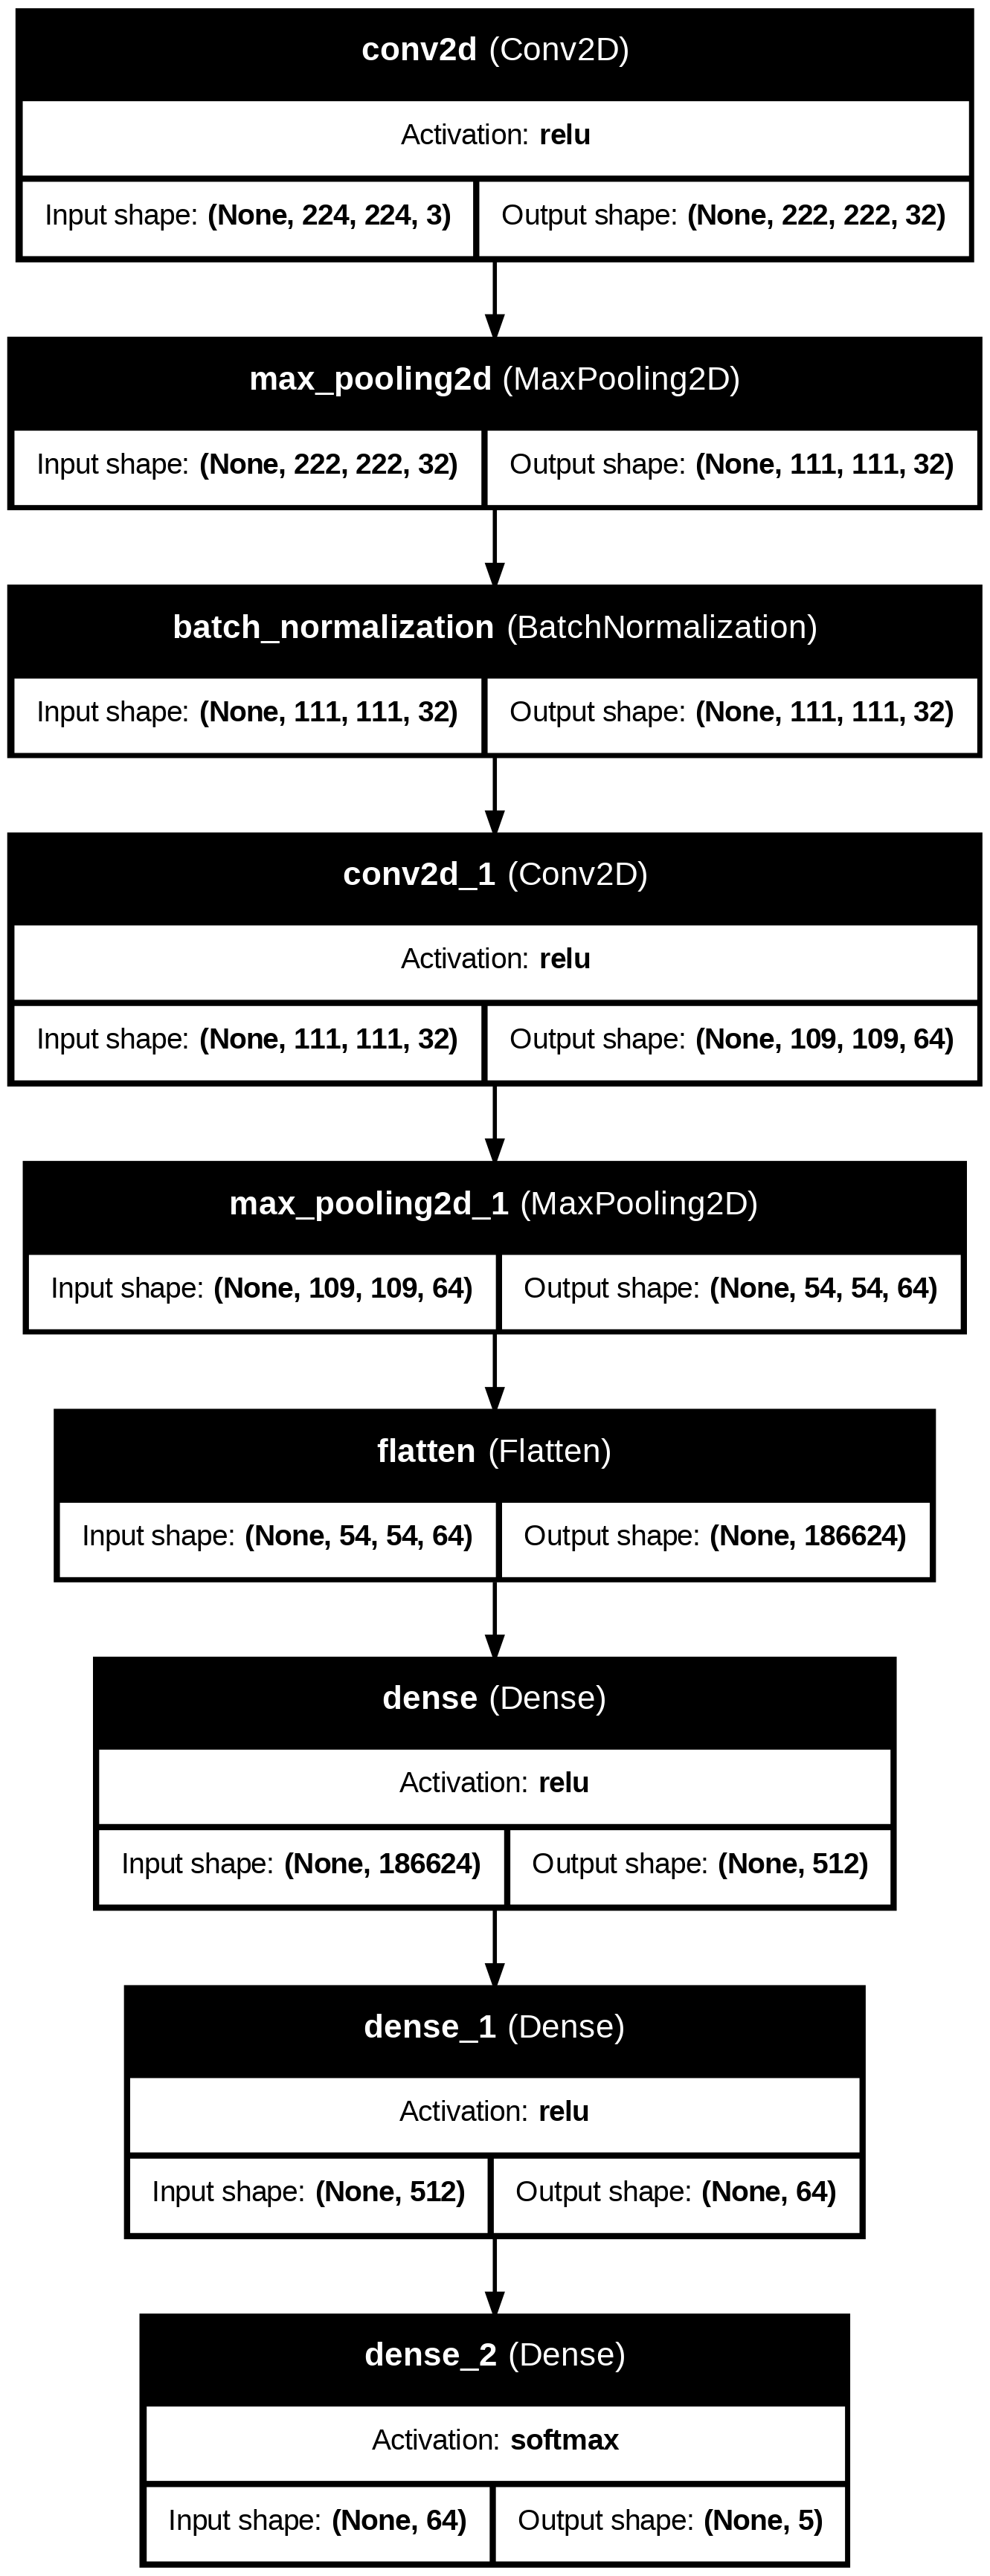

In [10]:
# Plot our defines model by keras.utils.plot_model
keras.utils.plot_model(
    model,                        # A Keras model instance
    to_file="model.png",          # "name.format" to save with
    show_shapes=True,            # Whether to display shape information
    show_dtype=False,             # Whether to display layer dtypes
    show_layer_names=True,       # Whether to display layer names
    rankdir="TB",                 # An argument passed to PyDot librariy
    expand_nested=False,          # whether to expand nested Functional models into clusters
    dpi=200,                      # Image resolution in dots per inch
    show_layer_activations=True, # Display layer activations
    show_trainable=False,         # whether to display if a layer is trainable.
)

# **Model Training and Compile**

In [14]:
# Model CheckPoint Call-Back, to save best model parameters as a .keras file
checkpoint_cb = keras.callbacks.ModelCheckpoint('MyModel.keras', save_best_only=True) 

# ReduceLROnPlateau Call-Back to decrease learning-rate base on 'monitor' parameter after 'patience' epochs with a 'factor' is doesn't improve
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)


# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adadelta(learning_rate=0.01), metrics=['accuracy'])

num_epochs = 10

history = model.fit(train_generator,epochs=num_epochs,validation_data=test_generator,
                    callbacks=[checkpoint_cb, reduce_lr]
                    )

Epoch 1/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 124s 32ms/step - accuracy: 0.9974 - loss: 0.0081 - val_accuracy: 0.9920 - val_loss: 0.0289 - learning_rate: 0.0100
Epoch 2/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 114s 30ms/step - accuracy: 0.9974 - loss: 0.0079 - val_accuracy: 0.9928 - val_loss: 0.0285 - learning_rate: 0.0100
Epoch 3/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 108s 29ms/step - accuracy: 0.9983 - loss: 0.0060 - val_accuracy: 0.9920 - val_loss: 0.0290 - learning_rate: 0.0100
Epoch 4/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 117s 31ms/step - accuracy: 0.9979 - loss: 0.0070 - val_accuracy: 0.9919 - val_loss: 0.0280 - learning_rate: 0.0100
Epoch 5/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 120s 32ms/step - accuracy: 0.9981 - loss: 0.0055 - val_accuracy: 0.9929 - val_loss: 0.0274 - learning_rate: 0.0100
Epoch 6/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 105s 28ms/step - accuracy: 0.9985 - loss: 0.0045 - val_accuracy: 0.9912 - val_loss: 0.0336 - learning_rate: 0.0100
Epoch 7/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 108s 29ms/step -

# **Training Result**

In [15]:
# Convert resutl of training to a DataFrame
result_df = pd.DataFrame(history.history)
# Show the result
print(result_df)

   accuracy      loss  val_accuracy  val_loss  learning_rate
0  0.997150  0.009053      0.992000  0.028902          0.010
1  0.997267  0.008476      0.992800  0.028524          0.010
2  0.997783  0.007127      0.992000  0.029020          0.010
3  0.997967  0.006517      0.991867  0.028017          0.010
4  0.998033  0.005955      0.992933  0.027446          0.010
5  0.998317  0.005528      0.991200  0.033572          0.010
6  0.998500  0.004945      0.992267  0.028791          0.010
7  0.998533  0.004653      0.992000  0.030363          0.010
8  0.999167  0.002871      0.992667  0.028892          0.005
9  0.999200  0.002617      0.992400  0.032526          0.005


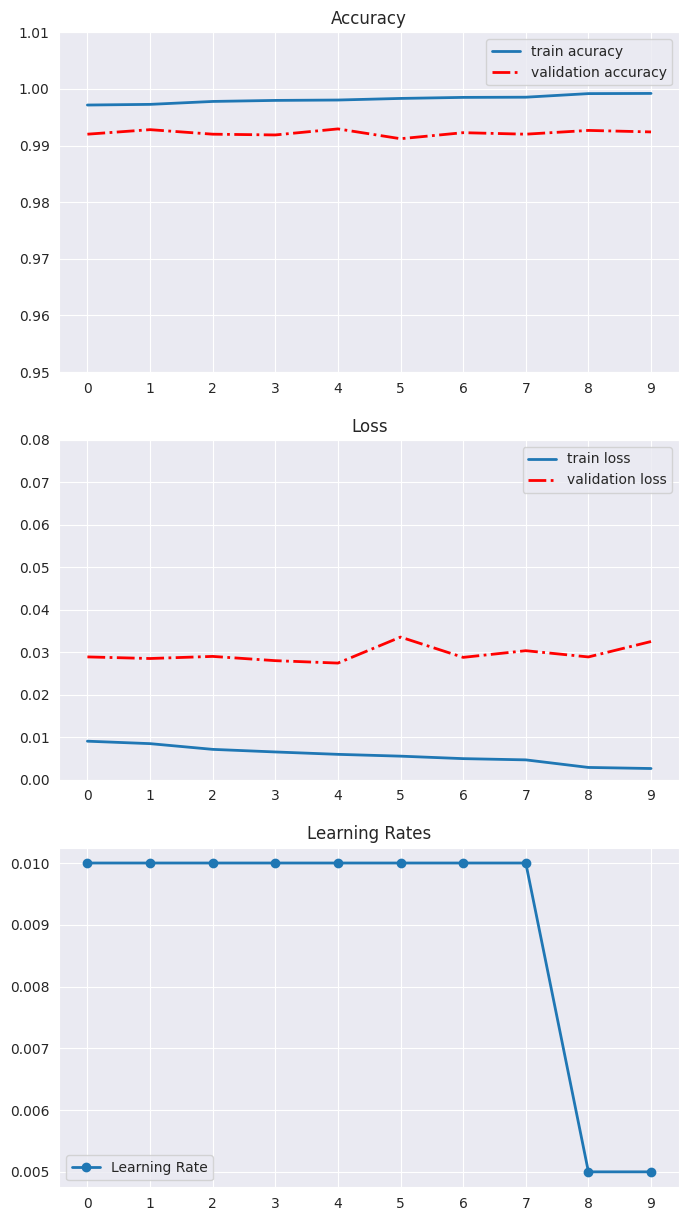

In [16]:
# Define a X variable to store range of epochs
x = np.arange(len(result_df))

# ax[0] ---> Accuracy
fig, ax = plt.subplots(3, 1, figsize=(8, 15))
ax[0].plot(x, result_df.accuracy, label='train acuracy', linewidth=2)
ax[0].plot(x, result_df.val_accuracy, label='validation accuracy', linewidth=2, ls='-.', c='r')
ax[0].set_title('Accuracy')
ax[0].set_yticks(np.arange(0.95, 1.01, 0.01))
ax[0].set_xticks(np.arange(0, num_epochs, 1))
ax[0].legend()

# ax[1] ---> Loss
ax[1].plot(x, result_df.loss, label='train loss', linewidth=2)
ax[1].plot(x, result_df.val_loss, label='validation loss', linewidth=2, ls='-.', c='r')
ax[1].set_title('Loss')
ax[1].set_xticks(np.arange(0, num_epochs, 1))
ax[1].set_yticks(np.arange(0, 0.085, 0.01))
ax[1].legend()

# ax[2] ---> Learning Rate
ax[2].plot(x, result_df.learning_rate, label='Learning Rate', linewidth=2, marker='o')
ax[2].set_title('Learning Rates')
ax[2].set_xticks(np.arange(0, num_epochs, 1))
ax[2].legend()

plt.show()

# **Evaluation**

In [17]:
# checkpoint callback, save base model weights in "MyModel.keras".
# So, we should load it by keras.models.load_model
best_model = keras.models.load_model('MyModel.keras')

In [18]:
# Evaluate model by model.evaluate()
loss, accuracy = best_model.evaluate(test_generator)
print()
print(colored(f'Loss : {loss:.5f}', 'green', attrs=['bold']))
print(colored(f'Accuracy : {round(accuracy, 5) * 100}%', 'green', attrs=['bold']))

469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.9926 - loss: 0.0312

Loss : 0.02745
Accuracy : 99.29299999999999%


# **Result Analysis**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


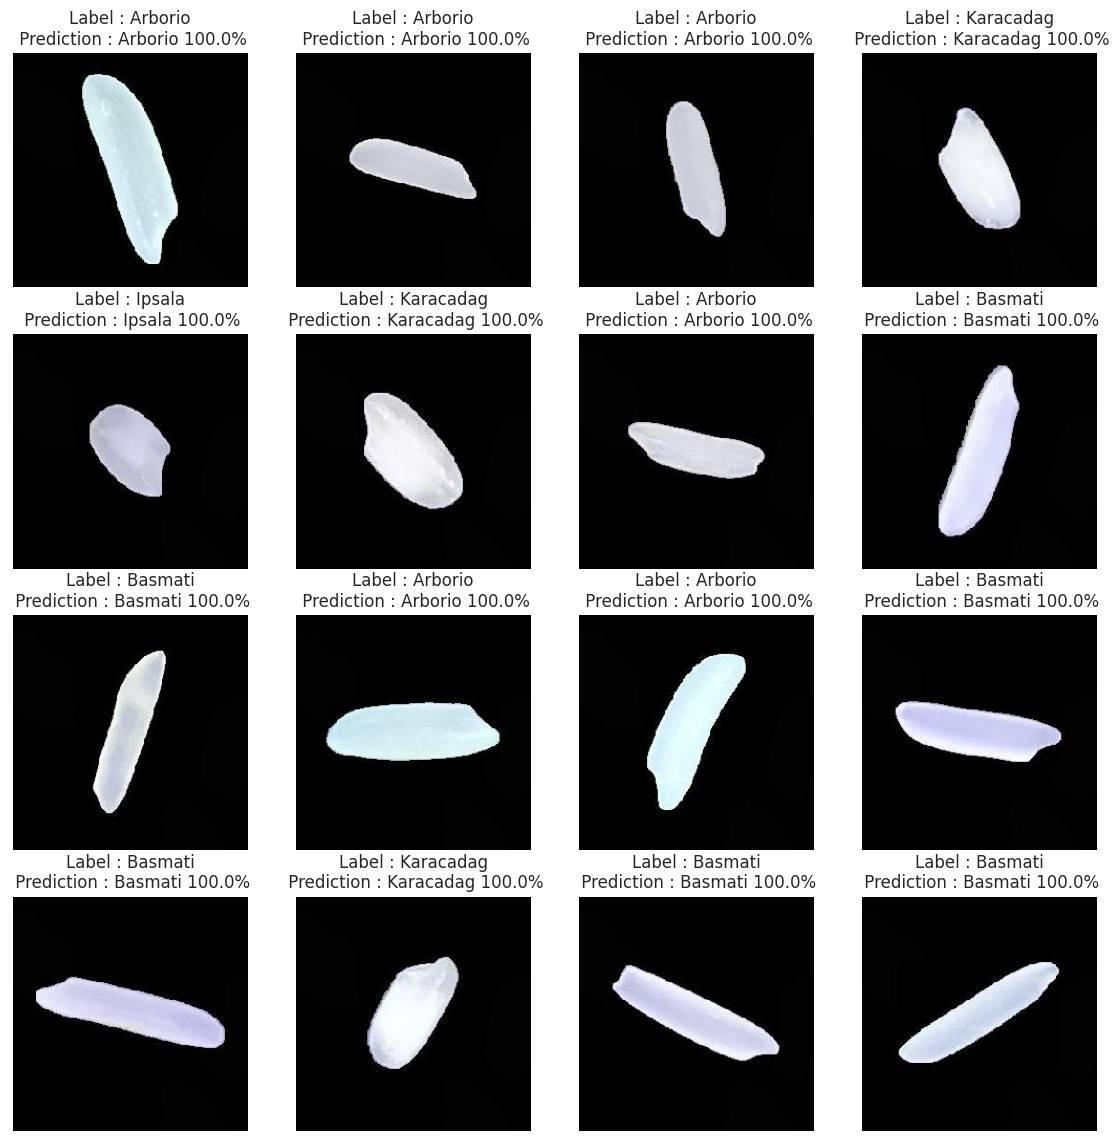

In [35]:
test_generator.reset()
img, label = next(test_generator)

prediction = model.predict(img)
test_pred_classes = np.argmax(prediction, axis=1)

plt.figure(figsize=[14, 14])
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(img[i])
    plt.axis('off')
    plt.title("Label : {}\n Prediction : {} {:.1f}%".format(classes[np.argmax(label[i])], classes[test_pred_classes[i]], 100 * np.max(prediction[i])))
plt.show()

In [36]:
y_pred = model.predict(test_generator, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

clf_report = classification_report(test_generator.classes, y_pred_bool, target_names=classes)

print(clf_report)

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step
              precision    recall  f1-score   support

   Karacadag       0.98      1.00      0.99      1509
     Basmati       0.99      0.99      0.99      1483
     Jasmine       1.00      1.00      1.00      1493
     Arborio       0.99      0.99      0.99      1481
      Ipsala       1.00      0.98      0.99      1534

    accuracy                           0.99      7500
   macro avg       0.99      0.99      0.99      7500
weighted avg       0.99      0.99      0.99      7500



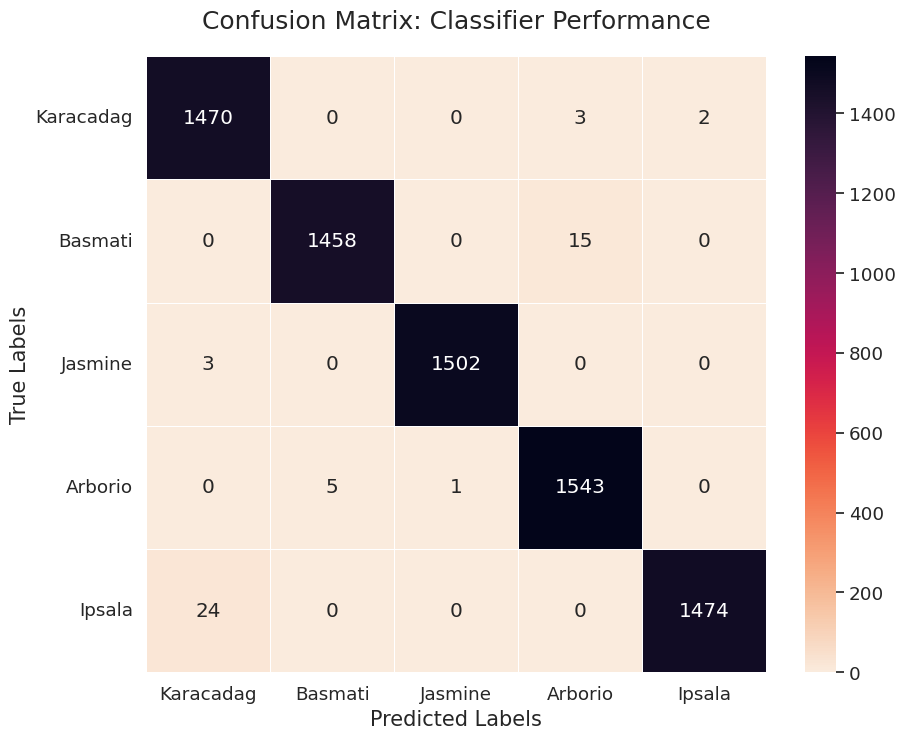

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Define the Confusion Matrix data from your image
# Input the values as a NumPy array
cm_data = np.array([
    [1470, 0, 0, 3, 2],
    [0, 1458, 0, 15, 0],
    [3, 0, 1502, 0, 0],
    [0, 5, 1, 1543, 0],
    [24, 0, 0, 0, 1474]
])

# 2. Define the class labels
labels = ['Karacadag', 'Basmati', 'Jasmine', 'Arborio', 'Ipsala']

# 3. Convert to a Pandas DataFrame for better Seaborn integration
cm_df = pd.DataFrame(cm_data, index=labels, columns=labels)

# 4. Plot the Heatmap using Seaborn
plt.figure(figsize=(10, 8)) # Set the plot size
sns.set(font_scale=1.2) # Increase the font scale for better readability

# Create the heatmap:
# - annot=True: Display the value inside each cell
# - fmt='d': Format the values as integers (d stands for decimal integer)
# - cmap='rocket_r': A visually appealing reverse dark-red/purple gradient.
#                    You can try 'viridis', 'magma', 'YlGnBu', or 'Blues'
# - linewidths=0.5: Add thin white lines to separate cells
# - linecolor='white': Color of the separation lines
ax = sns.heatmap(
    cm_df,
    annot=True,
    fmt='d',
    cmap='rocket_r',
    linewidths=0.5,
    linecolor='white',
    cbar=True
)

# 5. Set titles and labels
ax.set_title('Confusion Matrix: Classifier Performance', fontsize=18, pad=20)
ax.set_xlabel('Predicted Labels', fontsize=15)
ax.set_ylabel('True Labels', fontsize=15)

# Rotate Y-axis ticks for better readability
plt.yticks(rotation=0)

# 6. Display the plot
plt.show()
